In [1]:
using Pkg


cd(@__DIR__)
Pkg.activate("../")
ParamFile = "../config/testparam.csv" # 1D Earth/Mars/Moon models are defined

include("../src/commonBatchs.jl")
include("../src/planet1D.jl")
include("../src/GeoPoints.jl")

include("../src/Neurthino.jl")

using .commonBatchs, .planet1D, .GeoPoints
using .Neurthino 
using Colors


  Activating project at `~/Documents/Github/flexOPT`


In [97]:
using CairoMakie,DSP

In [112]:

function filterData(data,dt,f1,f2;np=4)
    fs = 1 /dt/2.0
    bp = digitalfilter(
            Bandpass(f1/fs, f2/fs),
            Butterworth(np)
        )

    filtered = filtfilt(bp, data)
    return filtered
end
# --- IBM float conversion ---
function ibm_to_float32(x::UInt32)
    if x == 0
        return 0.0f0
    end
    sign = (x & 0x80000000) != 0 ? -1.0f0 : 1.0f0
    exponent = Int((x >> 24) & 0x7f) - 64
    mantissa = Float32(x & 0x00ffffff) / 0x01000000
    return sign * mantissa * 16.0f0^exponent
end
function readSegy(file)
    t=nothing
    data=nothing
    open(file, "r") do io
        
        # ---- Read binary header ----
        seek(io, 3200 + 16)
        dt = ntoh(read(io, Int16))
        
        seek(io, 3200 + 20)
        ns = ntoh(read(io, Int16))
        
        seek(io, 3200 + 24)
        format = ntoh(read(io, Int16))
        
        println("dt = ", dt)
        println("ns = ", ns)
        println("format = ", format)

        # ---- Compute number of traces ----
        filesize = stat(file).size
        trace_size = 240 + 4*ns
        ntr = Int((filesize - 3600) ÷ trace_size)
        println("ntr = ", ntr)

        # ---- Read traces ----
        data = zeros(Float32, ns, ntr)

        seek(io, 3600)

        for i in 1:ntr
            read(io, 240)
            raw = read!(io, Vector{UInt32}(undef, ns))

            data[:, i] .= ibm_to_float32.(ntoh.(raw))
        end

        # ---- Time axis ----
        t = (0:ns-1) .* (dt/1e6)

    end
    return t, data
end

readSegy (generic function with 1 method)

In [102]:
t1,data1=readSegy( "../dataObs/seismo2026/1.sgy")
t2,data2=readSegy( "../dataObs/seismo2026/2.sgy")

dt = 16000
ns = 16000
format = 1
ntr = 24
dt = 250
ns = 12000
format = 1
ntr = 216


(0.0:0.00025:2.99975, Float32[-571.4507 -677.75073 … 684.9768 618.7556; -2979.2695 -326.0337 … 77.17389 522.9458; … ; 1273.6628 1778.0481 … -272.5464 -397.95972; 1274.9456 1780.0605 … -191.16048 -570.44336])

In [103]:
t1

0.0:0.016:255.984

In [104]:
t=t2;
data=data2[:,1:24];

In [105]:
function getSubSet(data,component,shotNumber)
    if component == "V"
        iVector = collect(1:8)*3
    elseif component == "H1"
        iVector = collect(1:8)*3 .-1
    elseif component == "H2"
        iVector = collect(1:8)*3 .-2
    end
    offset = (shotNumber-1)*24
    iVector=iVector.+offset
    newData= data[:,iVector]
end

getSubSet (generic function with 1 method)

In [123]:


function makeJolieFigure(t2,data2,startTime,endTime,shotNumber;f1=nothing,f2=nothing,np=4)

    t= t2
    data = getSubSet(data2,"V",shotNumber)

    Δt = t2[2]-t2[1]
    startInt = maximum([1, Int(startTime/Δt)+1])
    endInt = minimum([length(t),Int(endTime/Δt)+1])

    fig = Figure(size = (700,500))
    ax = Axis(fig[1,1],
        xlabel = "Time (s)",
        ylabel = "Distance from the tree (m)")


    
    for i in 1:size(data,2)
        if f1 !== nothing && f2 !== nothing
            data[:,i] = filterData(data[:,i],Δt,f1,f2;np=np)
        end
        lines!(ax, t[startInt:endInt], data[startInt:endInt,i]./maximum(data[startInt:endInt,i]) .* 3.0 .+(i-2)*5.e0,color = :black)
    end

    t= t2
    data = getSubSet(data2,"H1",shotNumber)

    for i in 1:size(data,2)
        if f1 !== nothing && f2 !== nothing
            data[:,i] = filterData(data[:,i],Δt,f1,f2;np=np)
        end
        lines!(ax, t[startInt:endInt], data[startInt:endInt,i]./maximum(data[startInt:endInt,i]) .* 3.0 .+(i-2)*5.e0,color = :red)
    end

    t= t2
    data = getSubSet(data2,"H2",shotNumber)

    for i in 1:size(data,2)
        if f1 !== nothing && f2 !== nothing
            data[:,i] = filterData(data[:,i],Δt,f1,f2;np=np)
        end
        lines!(ax, t[startInt:endInt], data[startInt:endInt,i]./maximum(data[startInt:endInt,i]) .* 3.0 .+(i-2)*5.e0,color = :blue)
    end


    fig

end


makeJolieFigure (generic function with 1 method)

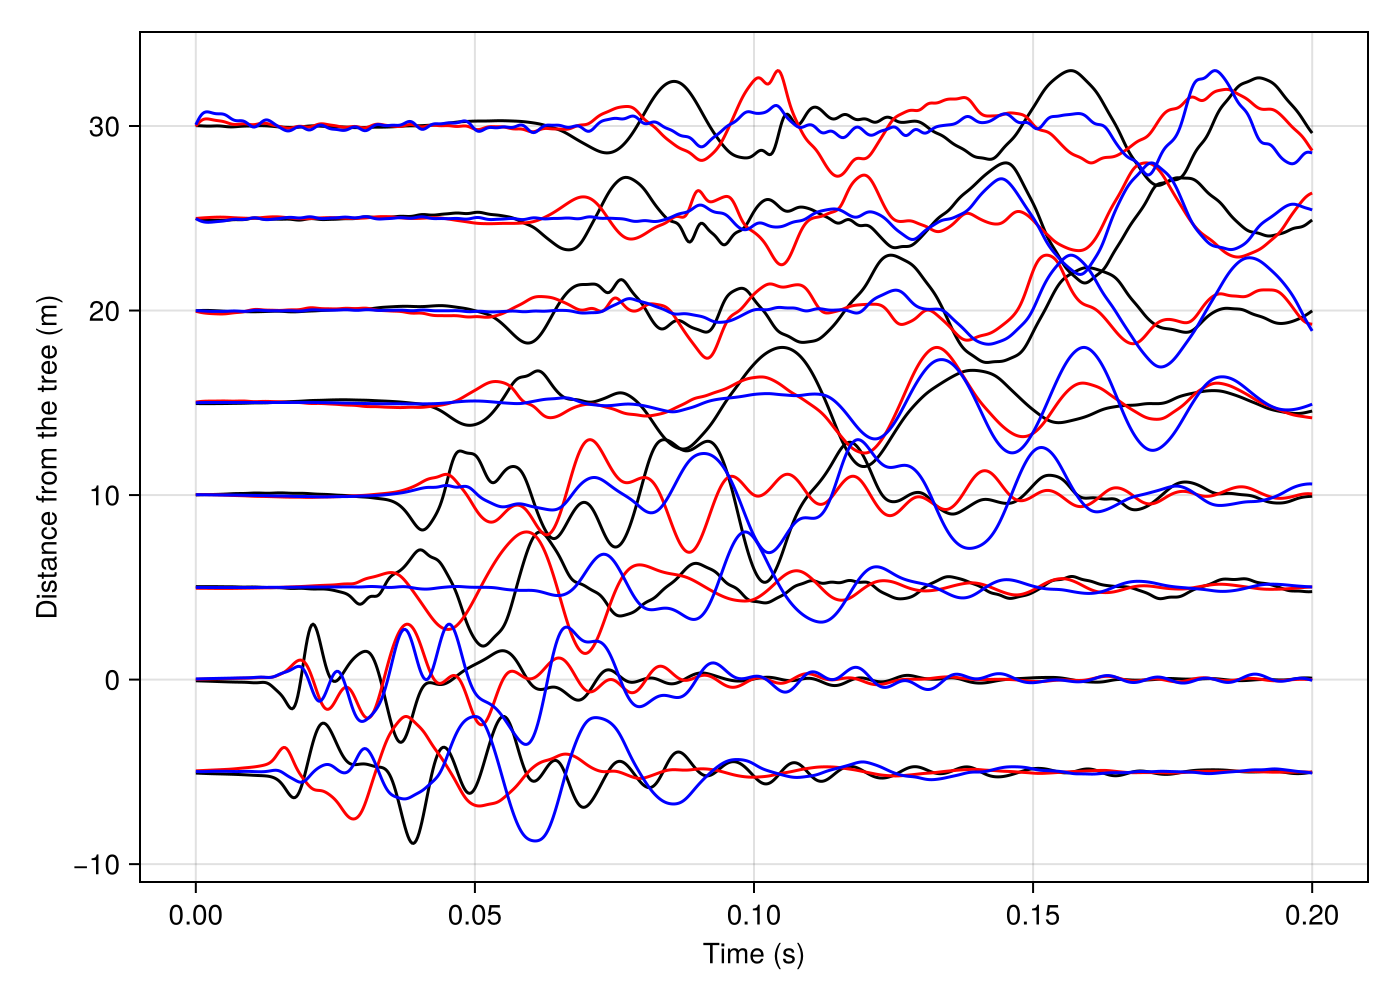

In [129]:
makeJolieFigure(t2,data2,0.0,0.2, 6;f1=20.0,f2=300.0)

In [70]:
size(t)

(12000,)